In [1]:
from pathlib import Path
import subprocess
import geopandas as gpd
import hvplot.pandas 
import holoviews as hv
import geoviews as gv
import matplotlib as mpl

hv.extension('bokeh')

# Select reservoir

In [9]:
start_date = '2020-01-01'
end_date = '2024-06-27'
RESERVOIR = '0193'
buffer_amt = 1000 # meters

s6_savedir = Path('../data/s6/raw')
s6_savedir.mkdir(exist_ok=True)

<Axes: >

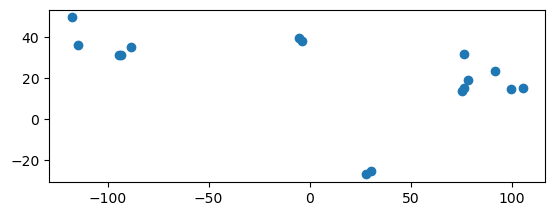

In [10]:
# read the bounding box of the study area
### subset OF 11 reservoirs
# val_pts = gpd.read_file(Path('/tiger1/pdas47/tmsosPP/data/validation-locations/mini-reservoirs-subset-validation-pts.geojson'))
# val_polys = gpd.read_file(Path('/tiger1/pdas47/tmsosPP/data/validation-locations/mini-reservoirs-subset-validation.geojson'))
### all 100 reservoirs
val_pts = gpd.read_file(Path('/tiger1/pdas47/tmsosPP/data/validation-locations/validation-reservoirs-grand-pts.geojson'))
val_polys = gpd.read_file(Path('/tiger1/pdas47/tmsosPP/data/validation-locations/validation-reservoirs-grand.geojson'))

selected_reservoirs = [
    '0505', # dumboor. India
    '0810', # sirindhorn, Thailand.
    '0830', # Krasoew, Thailand.
    '0502', # Bhakra dam, India.
    '0518', # Bhadra, India.
    '0349', # vaaldam, South Africa.
    '0464', # Sterkspruit, South Africa.
    '0214', # Cijara, Spain
    '1498', # Toledo bend, US
    '0936', # Arrow, Canada
    '1078', # Lake Mead, US,
    '0524', # Tungabhadra, India. Has both nadir and swath.
    '0486', # Sriram Sagar, India. Has both nadir and swath.
    '1284', # Sam Rayburn, US. Has both nadir and swath.
    '1385', # Pickwick Landing, US. Has both nadir and swath.
    '0193', # Giribaile, Sp. Has j3/s6 tracks
]
res_names = {
    '0505': 'Dumboor, In',
    '0810': 'Sirindhorn, Th',
    '0830': 'Krasoew, Th',
    '0502': 'Bhakra, In',
    '0518': 'Bhadra, In',
    '0349': 'Vaaldam, SA',
    '0464': 'Sterkspruit, SA',
    '0214': 'Cijara, Sp',
    '1498': 'Toledo Bend, US',
    '0936': 'Arrow, Ca',
    '1078': 'Lake Mead, US',
    '0524': 'Tungabhadra, In',
    '0486': 'Sriram Sagar, In',
    '1284': 'Sam Rayburn, US',
    '1385': 'Pickwick Landing, US',
    '0193': 'Giribaile, Sp',
}

val_res_pt = val_pts.loc[val_pts['tmsos_id'].isin(selected_reservoirs)]
val_res_poly = val_polys.loc[val_polys['tmsos_id'].isin(selected_reservoirs)]

val_res_pt.plot()

In [11]:
RESERVOIR_NAME = res_names[RESERVOIR]
print(f'{RESERVOIR}: {RESERVOIR_NAME}')

0193: Giribaile, Sp


<Axes: >

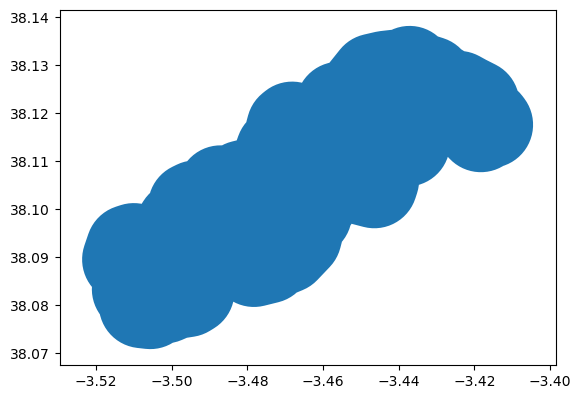

In [12]:
roi = val_res_poly[val_res_poly['tmsos_id']==RESERVOIR]
utm_crs = roi.estimate_utm_crs()
buffered_roi_utm = roi.to_crs(utm_crs).geometry.buffer(buffer_amt)
buffered_roi = buffered_roi_utm.to_crs('epsg:4326')
buffered_roi.plot()

## S6 - determine pass numbers

Sentinel-6 and Jason-3 follow the same ground tracks.

<Axes: >

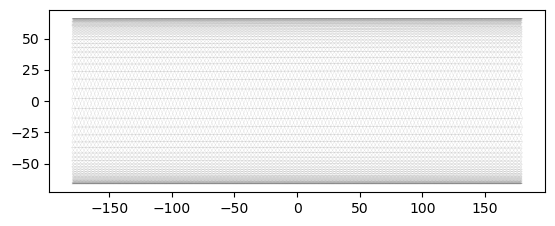

In [13]:
gd_track_fn = Path('/tiger1/pdas47/tmsosPP/data/j3_s6_tracks/j3_tracks.geojson')
gd_track = gpd.read_file(gd_track_fn)
gd_track.plot(facecolor='none', edgecolor='gray', lw=0.1, alpha=0.7)

In [14]:
import numpy as np

def j3_s6_intersect(gd_track, roi, slope_threshold=0.01):
    # shapefile of j3 and s6 tracks have horizontal lines, which are are not actually the orbit of these satellites.
    # the multiline feature that denotes the actual ground track of the orbit is split at 180° longitude. The horizontal line is the result of this split, joining the two ends of the split geometry.
    # a simple intersection of the roi with the gd_track will not work because of this. So we need to also check if the roi intersects with this artifant. Checking the slope of the intersect can help us determine if it is the actual orbit or the artifact.
    naive_intersect = gd_track[gd_track.intersects(roi.geometry.values[0])]

    if len(naive_intersect) != 0:
        intersection_geometry = naive_intersect.geometry.values[0].intersection(roi.geometry.values[0])
        intersection_bounds = intersection_geometry.bounds
        x_len = intersection_bounds[2] - intersection_bounds[0]
        y_len = intersection_bounds[3] - intersection_bounds[1]
        if y_len/x_len > slope_threshold:
            return naive_intersect
        else:
            return None
    else:
        return None

gd_track_subset = j3_s6_intersect(gd_track, buffered_roi)

if gd_track_subset is None:
    raise Exception('No intersection found.')

roi_gdf = gpd.GeoDataFrame(buffered_roi).rename({0: 'geometry'}, axis=1)
roi_gdf = roi_gdf.set_geometry('geometry')
roi_gdf['name'] = RESERVOIR_NAME
roi_hv = roi_gdf.hvplot(geo=True, alpha=0.8)

cmap = mpl.colormaps['inferno']
gd_track_subset['color'] = [mpl.colors.rgb2hex(cmap(i)) for i in np.linspace(0, 1, len(gd_track_subset.groupby('track')))]
tracks_hv = gd_track_subset.hvplot(
    geo=True, tiles='OSM', color=gd_track_subset['color'], alpha=0.5, line_width=2,
    xlim=(int(buffered_roi.total_bounds[0])-1, int(buffered_roi.total_bounds[2])+1),
    ylim=(int(buffered_roi.total_bounds[1])-1, int(buffered_roi.total_bounds[3])+1),
    tools=['hover'], hover_cols=['ID_PASS']
)

(tracks_hv * roi_hv).opts(
    title=f"Sentinel-6 Ground Tracks over {RESERVOIR_NAME}", width=400
)

/tiger1/pdas47/tmsosPP/.env/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Path.I     :Path   [Longitude,Latitude]   (_color)
   .Polygons.I :Polygons   [Longitude,Latitude]

In [15]:
gd_track_subset

,track,geometry,color
95,96,"LINESTRING Z (-69.3717 66.14645 0, -68.00124 6...",#000004


# Download sentinel-6 data

## Automated download

In [18]:
import subprocess
import pandas as pd

def download_s6_for_reservoir(roi, start_date, end_date, download_dir):
    # by bounds. 
    roi = roi.to_crs('epsg:4326')
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    download_dir = Path(download_dir)
    bounds = ",".join([f"{x:.3f}" for x in roi.total_bounds])

    print(bounds)
    podaac_cmd = [
        'podaac-data-downloader',
        '-c', 'JASON_CS_S6A_L2_ALT_HR_STD_OST_NRT_F',
        '-d', str(download_dir), 
        rf'-b="{bounds}"',
        '--start-date', pd.to_datetime(start_date).strftime('%Y-%m-%dT%XZ'),
        '--end-date', pd.to_datetime(end_date).strftime('%Y-%m-%dT%XZ'),
    ]

    res = subprocess.run(" ".join(podaac_cmd), shell=True, capture_output=True, text=True)
    return res

s6_savedir = Path('../data/s6/raw')

def download_s6_passes(passes, start_date, end_date, download_dir):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    download_dir = Path(download_dir)
    bounds = ",".join([f"{x:.3f}" for x in roi.total_bounds])
    results = []

    for pass_id in passes:
        podaac_cmd = [
            'podaac-data-downloader',
            '-c', 'JASON_CS_S6A_L2_ALT_HR_STD_OST_NRT_F',
            '-d', str(download_dir), 
            '-gr', f'*_{pass_id:03}_*.nc',
            rf'-b="{bounds}"', 
            '--start-date', pd.to_datetime(start_date).strftime('%Y-%m-%dT%XZ'),
            '--end-date', pd.to_datetime(end_date).strftime('%Y-%m-%dT%XZ'),
        ]
        res = subprocess.run(" ".join(podaac_cmd), shell=True)
        results.append(res)
    
    return results


download_s6_passes(
    gd_track_subset['track'], start_date, end_date, s6_savedir
)

[2024-07-20 00:04:10,132] {podaac_data_downloader.py:358} INFO - 2024-07-20 00:04:10.132129 SUCCESS: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/JASON_CS_S6A_L2_ALT_HR_STD_OST_NRT_F/S6A_P4_2__HR_STD__NR_108_096_20231018T090453_20231018T091453_F08.nc
[2024-07-20 00:04:11,042] {podaac_data_downloader.py:358} INFO - 2024-07-20 00:04:11.041990 SUCCESS: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/JASON_CS_S6A_L2_ALT_HR_STD_OST_NRT_F/S6A_P4_2__HR_STD__NR_108_096_20231018T085456_20231018T090453_F08.nc
[2024-07-20 00:04:11,903] {podaac_data_downloader.py:358} INFO - 2024-07-20 00:04:11.903101 SUCCESS: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/JASON_CS_S6A_L2_ALT_HR_STD_OST_NRT_F/S6A_P4_2__HR_STD__NR_108_096_20231018T084312_20231018T085241_F08.nc
[2024-07-20 00:04:12,625] {podaac_data_downloader.py:358} INFO - 2024-07-20 00:04:12.625095 SUCCESS: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protect

[CompletedProcess(args='podaac-data-downloader -c JASON_CS_S6A_L2_ALT_HR_STD_OST_NRT_F -d ../data/s6/raw -gr *_096_*.nc -b="-3.512,38.080,-3.416,38.129" --start-date 2020-01-01T00:00:00Z --end-date 2024-06-27T00:00:00Z', returncode=0)]

## Earthdata
Currently trying out Earthdata to quickly download data and apply the processing code to obtain elevations from sentinel-6. TODO: automated access to sentine-6. This repository contains example notebooks to do so - https://github.com/podaac/sentinel6/tree/master.

In [24]:
import subprocess
from tqdm.auto import tqdm

links_fp = Path(f'../data/s6/earthdata_links/{RESERVOIR}.txt')
links = links_fp.read_text().split('\n')

for link in tqdm(links):
    print(f'Downloading {link}')
    cmd = f'wget -nc -P {s6_savedir.absolute()} {link}'
    res = subprocess.run(cmd.split(' '), capture_output=True, text=True)
    print("downloaded successfully" if res.returncode == 0 else "download failed")

  0%|          | 0/207 [00:00<?, ?it/s]

downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded succe